In [1]:
%matplotlib inline

In this unit, we will use the travel time information computed in the previous unit for arrival time prediction. The arrival time prediction is computed using the travel time estimates between the pair of bus-stop $(i,i+1)$. The travel time estimation is based on the weights and estimates pre-computed using historical trips. Concretely, we compute the mean of the bus travel time between the pair of bus-stop $(i,i+1)$ in the historical trips. As these are the historical trips, the weights and estimates can be computed in off-load time of the server, when the load on the server is relatively less. We will discuss the weight and estimation computation followed by the discussion about the arrival time prediction.

# Weight and estimate computation
In our application, we select one of the trips from the available location records as the ongoing trip and compute the arrival time prediction for it. In this case, the weights and estimates are computed using remaining trips for every pair of bus-stops $(i,i+1)$ on a route. 

For a pair of bus-stop, the temporal estimate is computed as the mean of travel time of the recorded trips in the same  `TripStartHour`. The weights and estimates are computed for the trips starting at different `TripStartHour` separately. The reason for separate computation is that the traffic dynamics throughout the day would be different and at the same time it would not change rapidly. We consider the trips that have the same `TripStartHour` would be plying on a route with the same traffic dynamics and hence, by computing weights and estimates at different `TripStartHour` separately, we cater for time-varying traffic dynamics. 

$$ T^{pt}(i, i+1) = \frac{1}{n} \sum_{j=1}^{n} T_j(i, i+1) $$

Likewise, the spatial estimate is computed as the mean of the fraction of travel time between pair $(i-1,i)$ and $(i,i+1)$. 

$$F^{ps} (i, i+1) =   \frac{1}{n} \sum_{j=1}^{n} \left( \frac{T_j(i, i+1)}{T_j(i-1, i)} \right)$$

The corresponding weights $w^{pt}$ and $w^{ps}$ are computed using the variance of the travel time $\sigma^{pt} (i,i+1)$ between the pair of bus-stop $(i,i+1)$ and the variance in the fraction of the travel time $\sigma^{ps} (i,i+1)$ between pair $(i-1,i)$ and $(i,i+1)$ as given below. 

$$W^{pt} (i, i+1) =  \frac{\sigma^{ps} (i,i+1)}{\sigma ^{pt} (i,i+1) + \sigma ^{ps} (i,i+1)}$$

and 

$$W ^{ps} (i, i+1)  =  1- W ^{pt} (i, i+1)$$

The weights are inversely proportional to the variance of the estimates and sums up to 1. We also compute the variance in the estimate ${STD}$ for computing the margin in the prediction as 

$$ STD = \sqrt{w^{pt}(i,i+1)^2 \times \frac{\sigma^{pt} (i,i+1)^2}{T^{pt}(i, i+1)} \times 100 + w^{ps}(i,i+1)^2 \times  \frac{\sigma^{ps} (i,i+1)^2}{T^{ps}(i, i+1)^2} \times 100 } $$

In the following, we will select one of the trips as ongoing and compute the weights and estimates using remaining trips. 

In [2]:
'''Imports'''
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, GridBox, Layout
import ipywidgets as widgets
from pymongo import MongoClient

import os
import sys
import pprint
import pandas as pd
sys.path.append("/".join(os.getcwd().split('/')) +'/Codes/LibCodes')

'''Import project specific library'''
import WeigthsForPredictor
import GH_Predictor, GH_PredictorPlot
'''Initialize MongoClient'''
con = MongoClient()

RouteName='Git_ISCON_PDPU'

In [3]:
'''For updating the lib changes effects'''
#'''
import importlib
importlib.reload(WeigthsForPredictor)
importlib.reload(GH_Predictor)
importlib.reload(GH_PredictorPlot)
#'''

<module 'GH_PredictorPlot' from '/home/pruthvish/JRF/GitVersionICDCN/Codes/LibCodes/GH_PredictorPlot.py'>

Let us extract the trips for which we have extracted location records corresponding to the bus-stops by querying `BusStopRecordExtracted` flag to be **True** and compute historical weights and estimates using function `WeigthsForPredictor.HistoricalWeights`.

In [4]:
SingleTripsInfo = [rec['SingleTripInfo'] for rec in 
                             con[RouteName]['TripInfo'].find({'BusStopRecordExtracted':True})]

WeigthsForPredictor.HistoricalWeights(SingleTripsInfo[0],RouteName)

The function `WeigthsForPredictor.HistoricalWeights` stores the weights and estimates in the collection `H.TripStartHour.Bound`. For instance, the collection `H.07.North` would have the estimates and weights for trips starting at *07* hours in *North bound* direction.

In [5]:
HistoricalWeightRecords = [rec for rec in con[RouteName]['H.07.North'].find()]
for Record in HistoricalWeightRecords:
    del Record['_id']

pd.DataFrame(HistoricalWeightRecords)

,Delta_ps,Delta_pt,F_ps_Available,F_ps_Mean,F_ps_STD,STD,T_pt_Available,T_pt_Mean,T_pt_STD,id,w_ps,w_pt
0,NaN,0.000000,False,NaN,NaN,0.000000,True,92000.000000,0.000000,0,NaN,1.000000
1,0.000000,29.429677,True,1.413043,0.000000,0.000000,True,134352.857143,39539.612072,1,1.000000,0.000000
2,43.377372,35.624758,True,0.486211,0.210905,27.662496,True,61097.333333,21765.777002,2,0.450934,0.549066
3,25.391495,17.970649,True,1.708430,0.433796,14.881828,True,96842.105263,17403.155061,3,0.414432,0.585568
4,13.290849,15.010500,True,2.106551,0.279978,9.969095,True,200900.000000,30156.093912,4,0.530381,0.469619
5,28.367482,23.751117,True,0.942747,0.267434,18.282143,True,187176.470588,44456.502593,5,0.455713,0.544287
6,21.255091,12.496206,True,0.765774,0.162766,11.129244,True,134722.222222,16835.166750,6,0.370244,0.629756
7,11.023317,8.334377,True,2.567393,0.283012,6.711921,True,344277.777778,28693.409146,7,0.430546,0.569454
8,41.951459,41.314275,True,0.808863,0.339330,29.437159,True,275235.294118,113711.466343,8,0.496174,0.503826
9,23.637914,9.635871,True,0.886769,0.209614,9.680837,True,222411.764706,21431.309761,9,0.289593,0.710407


Here,
- `Delta_pt` and `Delta_ps`: is the relative standard deviation in the travel time between pair of bus-stop $(i,i+1)$ and fraction of the travel time between the pair of bus-stop $(i-1,i)$ and $(i,i+1)$.
- `F_ps_Available`, `T_pt_Available`: indicates whether the estimate is available or not.
- `F_ps_Mean`, `F_ps_STD`: Mean and std deviation of spatial estimate.
- `T_pt_Mean`, `T_pt_STD`: Mean and std deviation of temporal estimate.
- `id`: id of bus-stop.
- `w_ps`, `w_pt`: weights of temporal and spatial estimate.

Kindly note that the spatial estimate is not available for `id: 0`. Because, the travel time of previous pair of bus-stop is not available. In this case, the weight of temporal estimate `w_pt` is 1.

# Arrival time prediction


Aforementioned, to develop the arrival time predictor scheme, we select one of the trips from the available location records as the ongoing trip and compute the arrival time prediction for it. We will use the `RawRecords` for prediction, as our scheme applies prediction algorithm on receiving the real-time location updates. The preprocessing steps, DBSCAN based bus-stop detection, and historical weights and estimates computation are applied on location records during the off-load time of the server, when load on the server is relatively less.

The arrival time prediction scheme applies the following steps on receiving the real-time location update
1. Extract bound and compute the arrival status of bus $(i,i+1)$. The bus-stop i where the bus has arrived and i+1 where the bus would be arriving.
2. Extract historical estimates $T^{pt}(i,i+1), F^{ps}(i,i+1)$ and weights $w^{pt},w^{ps}$ for pair of bus-stops $(i,i+1)$.
3. Predict arrival time for downstream bus-stops.

These steps are elaborated in the following:

**Step-1**

At the first step, we identify the bound of the bus-trip from the real-time location update by using function `GetBoundAndHData`. The function compares the location update with the first and last bus-stop on the route. If location update is nearer to first bus-stop, it marks the bus-trip as *North bound*, else marks as *South bound*. As during the start of the bus-trip, it is supposed to be nearer to the starting bus-stop of the bound compared with the last bus-stop.

**Step-2**

Further, for computing the arrival status of the bus, we compare the real-time location record with three consecutive bus-stops on the route, similar to the logic we applied while extracting the travel time information in the unit-2 to cater with *occasional GPS outage*. 

**Step-3**

Functions `GetArrivalStatusNorthBound` and  `PredictionAlgorithmSouthBound`, then applies the arrival time prediction for downstream bus-stops as follow:
Travel time $\hat{t}(i,i+1)$ for a pair of bus-stop is computed as:

$$\hat{t}(i,i+1) = w^{pt} (i,i+1) \times T^{pt} (i,i+1) + w^{ps} (i,i+1) \times T^{ps} (i,i+1)$$
where
$$T^{ps} (i,i+1) = F^{ps} (i,i+1) \times T^{ps} (i-1,i) $$


**Step-4**

The prediction for i+1 bus-stop would be 

$$\hat{t}(i+1) = t(i) + \hat{t}(i,i+1) \pm STD(i,i+1) \times \frac{\hat{t}(i,i+1)}{100} $$

where $t(i)$ is the arrival time of bus at $i^{th}$ stop. The last term gives the margin for prediction.

**Step-5**

Subsequently, for the downstream bus-stops: $(i+1)$ to Number of bus-stops less 1, the predicted time is considered as arrival time as follow,

$${t}(i+1) = \hat{t}(i+1)$$

and prediction steps 3, 4, and 5 are repeated to get the prediction at the downstream bus-stops. After the prediction of all the downstream bus-stops, the algorithm performs step-2 to compute the arrival status of the bus using real-time location updates. 

Thus, the bus arrival time prediction is computed for all the downstream bus-stop once the algorithm gets the location update. Subsequently, as the bus-trip progresses, these arrival time predition gets updated when the bus arrives at a bus-stop. In order to compute the arrival time prediction at the significant locations, the predictions are also updated at junctions or crossroads (detected using the DBSCAN algorithm) along with the pair of bus-stops. These junctions are termed as *Milestones* in our prediction scheme. Now, we shall look at an interactive demo of arrival time prediction using function `ArrivalTimePrediction`.

In [6]:
def ArrivalTimePrediction(index):
    '''
    input: The trip index for selection of one of the trips on which arrival time prediction will be performed
    output: The plot of actual travel time and predicted travel time
    function: Extracts the raw location records, and identifies the bound of the trip.
              Subsequently, the function computes the arrival time status and 
              applies the arrival time prediction scheme.

    '''
    LocationRecordsList = [Records for Records in 
                           con[RouteName][SingleTripsInfo[index]+'.RawRecords'].find().sort([('epoch',1)])]
    
    
    WeigthsForPredictor.HistoricalWeights(SingleTripsInfo[index],RouteName)
    
    
    '''Initialize the variables for arrival time prediction'''
    VariableDict = GH_Predictor.InitializeVariableDict()
    PredictionDictList = []
    
    '''Fetch bus-stop list'''
    BusStopsList = [BusStop for BusStop in con[RouteName]['BusStops.NorthBound'].find().sort([('id',1)])]
    BusStopsListSouthBound = [BusStop for BusStop in con[RouteName]['BusStops.SouthBound'].find().sort([('id',1)])]
    
    Dist_TH = 50
    for LocationRecord in LocationRecordsList:
        '''Every new entry in loop indicates the location update
        Calculate distance of location with respect to each stop Bound'''

        if VariableDict['Bound'] == '':
            VariableDict, HistoricalDataList= GH_Predictor.GetBoundAndHData(LocationRecord,
                                                                            BusStopsList,VariableDict,RouteName)
            VariableDict['BusStopIndex'] = 0
            
        elif VariableDict['Bound'] == 'North':
            VariableDict, ArrivedAtFlag = GH_Predictor.GetArrivalStatusNorthBound(LocationRecord,BusStopsList,
                                                                                  VariableDict,RouteName,Dist_TH)
            if ArrivedAtFlag==True: 
                VariableDict, PredictionDictList = GH_Predictor.PredictionAlgorithmNorthBound(LocationRecord,
                                                                                 BusStopsList,
                                                                                 HistoricalDataList,
                                                                                 VariableDict,PredictionDictList,
                                                                                             RouteName)
                
        elif VariableDict['Bound'] == 'South':
            '''BusStopsListSouth use'''
            BusStopsList = BusStopsListSouthBound
            VariableDict, ArrivedAtFlag = GH_Predictor.GetArrivalStatusSouthBound(LocationRecord,BusStopsList,
                                                                                  VariableDict,RouteName,Dist_TH)

            if ArrivedAtFlag == True:
                VariableDict, PredictionDictList = GH_Predictor.PredictionAlgorithmSouthBound(LocationRecord,
                                                                                 BusStopsList,
                                                                                 HistoricalDataList,
                                                                                 VariableDict,PredictionDictList,RouteName)
                
                
    con[RouteName].drop_collection(SingleTripsInfo[index]+'.PredictionResult_Dist_th_50')
    con[RouteName][SingleTripsInfo[index]+'.PredictionResult_Dist_th_50'].insert_many(PredictionDictList)
    
    GH_PredictorPlot.PlotPrediction(SingleTripsInfo[index],RouteName)
    

Let us select one of the trips from the historical trip records and look at arrival time prediction for the trip.

In [7]:
'''Display interactive arrival time prediction'''
SingleTripsInfo = [rec['SingleTripInfo'] for rec in 
                   con[RouteName]['TripInfo'].find({'BusStopRecordExtracted':True})]

index = widgets.Dropdown(options =[(SingleTripInfo,index) for index,SingleTripInfo in enumerate(SingleTripsInfo)],
                                  value=1, 
                                  description = 'Select trip' )

interact(ArrivalTimePrediction, index = index)

interactive(children=(Dropdown(description='Select trip', index=1, options=(('29_01_2018__07_39_47', 0), ('30_…

<function __main__.ArrivalTimePrediction(index)>

where 

B's are the bus-stops: B1: ISCON crossroads, B2: Pakwaan crossroads, B3: Gurudwara, B4: Thaltej crossroads, B5: Zydus crossroads, B6: Kargil petrol pump, B7: Sola crossroads, B8: PDPU and 

M's are the milestones: M1: Gota, M2: Vaishnodevi, M3: Khoraj, M4: Adalaj-Uvarsad crossroads, M5: Sargasan, M6: Raksha-shakti circle, M7: Bhaijipura.

The plot in red color represents the actual travel time of the bus-trip and the plot in green shows the arrival time prediction. We would like to emphasize that the margin of the arrival time prediction is represented using the error bar in the plot. Thus the prediction of the scheme would be like the bus would arrive in $5 \pm 1$  min. And the margin is based upon the variation in the historical travel time estimates that captures variation in the traffic condition of the route during different trip start hours. 

Let us look at the arrival time prediction for one of the evening trips. The trip will start from B8 and progress towards B1. For consistency in the plot, we mark the y-axis bus-stops in the same way as for *North bound* trips. And hence the arrival time prediction progresses from right to left as against *North bound*, where arrival time prediction progresses from left to right.

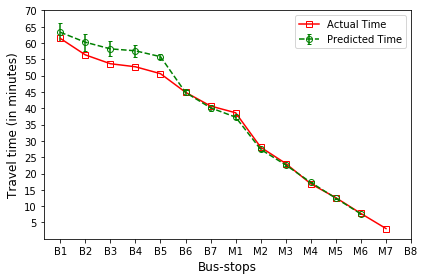

In [8]:
ArrivalTimePrediction(7) # for trip 22_12_2017__18_38_34